In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from lib.helpersmd import readFromDat
%matplotlib notebook

In [2]:
def rescaleImage(img,S=256):
    """ make all the values in the image in the scale 0..S, so could be fit within uint 
        input:
        -------------
          img : numpy array
          S   : scale parameter
        return 
          numpy array after rescaling the image
    """
    assert S<=256
    ret=np.zeros(img.shape)
    ret=S*((img-img.min())/float(1+img.max()-img.min()))
    return np.uint8(ret)
def negativeImage(img):
    """return negative of the image"""
    return 255-img
def adjust_gamma(img, gamma=1.0):
    """Gamma Correction
        input:
        ---------------
            img   : numpy array
            gamma : Gamma correction parameter
        
        output: return numpy array after applying Gamma correction
    """
    invGamma=1/gamma
    ret=img.copy()
    ret=ret/256.
    return np.uint8(256*(np.power(ret,invGamma)))

In [3]:
def mapCell(nh,nw,oh,ow,i,j):
    """ map (i,j)-->(oi,oj)
    Input:
    ---------------
        nh,nw: New dimensions of the image
        oh,ow: Origin/old dimensions of the image
        i,j  : coordinates of the cell in the new image
    return:
    -----------------
        (oi,oj): the corresponding coordinates in the origin image
    """
    return int(i*oh/float(nh)),int(j*ow/float(nw))
def resizeImage_NN(img,nh,nw,oh,ow):
    """ Resize image using 1-Nearest Neighbor Algorithm
        Input:
        --------------
            img: numpy array of shape (h,w) or (h,w,3)
            nh,nw: New dimensions of the image
            oh,ow: Origin/old dimensions of the image
        return numpy array with values of type uint, represents the image in the new dimensions
    """
    newdims=[nh,nw]+list(img.shape[2:])  # if the image RGB then add the third dimension (will be 3)
    newimg=np.zeros(tuple(newdims))
    for i in range(nh):
        for j in range(nw):
            ix,jx=mapCell(nh,nw,oh,ow,i,j)
            newimg[i,j]=img[ix,jx]
    return np.uint8(newimg)

In [4]:
def getHistogram(img,mx):
    return np.array([np.sum(img==i) for i in range(mx+1)])
def getCumSum(img,mx):
    return np.cumsum(getHistogram(img,mx))
def getNormalizedHistogram(img,mx,L):
    hist=getHistogram(img,mx)
    return np.round(L*((hist-hist.min())/(hist.max()-hist.min()+1.)))
def getNormalizedCumSum(img,mx,L):
    CDF=getCumSum(img,mx)
    return np.round(L*((CDF-CDF.min())/(CDF.max()-CDF.min()+1.)))
def equalizeImage1Channel(img):
    histogram=getHistogram(img,255)
    CDF=np.cumsum(histogram)
    histogram_normalized=getNormalizedHistogram(img,255,255)
    CDF_normalized=getNormalizedCumSum(jpgfile1,255,255)
    
    newImg=CDF_normalized[img]
    newHistogram=getHistogram(newImg,255)
    newCDF=getCumSum(newImg,255)
    newHistogram_normalized=getNormalizedHistogram(newImg,255,255)
    newCDF_normalized=getNormalizedCumSum(newImg,255,255)
    
    ret={"histogram":histogram,"CDF":CDF,"histogram_normalized":histogram_normalized,"CDF_normalized":CDF_normalized,
         "newHistogram":newHistogram,"newCDF":newCDF,"newHistogram_normalized":newHistogram_normalized,
         "newCDF_noramlized":newCDF_normalized}
    return newImg,ret
def equalizeImageRGB(img):
    newImg=np.zeros_like(img)
    newImg[:,:,0],ret1=equalizeImage1Channel(img[:,:,0])
    newImg[:,:,1],ret2=equalizeImage1Channel(img[:,:,0])
    newImg[:,:,2],ret3=equalizeImage1Channel(img[:,:,0])
    return newImg,[ret1,ret2,ret3]

In [5]:
import numpy as np
import os
import cv2
def noisy(image):
    row,col = image.shape
    s_vs_p = 0.5
    amount = 0.0004
    out = np.copy(image)
    # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
    out[coords] = 1

    # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
    out[coords] = 0
    return out

In [6]:
def medianFilter(model,startx,endx,starty,endy):
    block=model[startx:endx,starty:endy].flatten()
    block=np.sort(block)
    return block[block.shape[0]/2]
def meanFilter(model,startx,endx,starty,endy):
    block=model[startx:endx,starty:endy].flatten()
    return block.mean()

In [7]:
fx=350

<IPython.core.display.Javascript object>


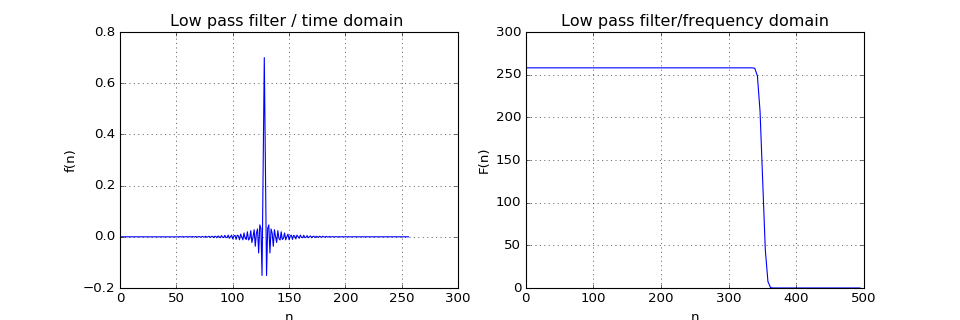

In [8]:
from lib.filtersmd import lpf
from lib.plotmd import plotVector, plot2D
from lib.signalprocessingmd import fourierTransform,getScaledDomain

fout=fx
m=128
dt=0.001
N=2*m+1
lpw=lpf(fout,m,dt)
_,Cn_lpw=fourierTransform(lpw)
Cn_lpw=Cn_lpw[:N/2]
Cn_lpw=Cn_lpw*(N+1)
fscaled=getScaledDomain(dt,N)[:N/2]

plt.figure(figsize=(12, 4), dpi=80)
plt.subplot(121)
plotVector(lpw,"Low pass filter / time domain ","n","f(n)")
plt.subplot(122)
plot2D(fscaled,Cn_lpw,"Low pass filter/frequency domain","n","F(n)")
plt.show()

<IPython.core.display.Javascript object>


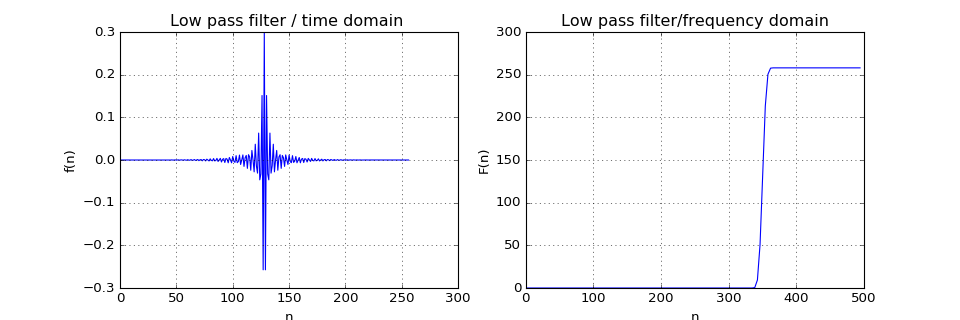

In [9]:
from lib.filtersmd import hpf
fc=fx
hpw=hpf(fc,m,dt)
_,Cn_hpw=fourierTransform(hpw)
Cn_hpw=Cn_hpw[:N/2]*(N+1)
fscaled=getScaledDomain(dt,N)[:N/2]

plt.figure(figsize=(12, 4), dpi=80)
plt.subplot(121)
plotVector(hpw,"Low pass filter / time domain ","n","f(n)")
plt.subplot(122)
plot2D(fscaled,Cn_hpw,"Low pass filter/frequency domain","n","F(n)")
plt.show()

<IPython.core.display.Javascript object>


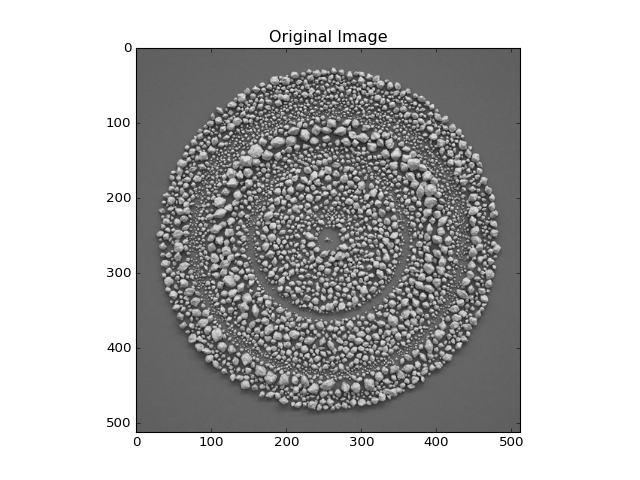

In [10]:
from PIL import Image
model = np.array(Image.open("./data/stones.jpg"))
model = (model-model.min())
size=model.shape
plt.figure()
plt.title('Original Image')
model=model[:,:,0]
imshow(model,cmap='gray')

In [11]:
model.shape

(512, 512)

<IPython.core.display.Javascript object>


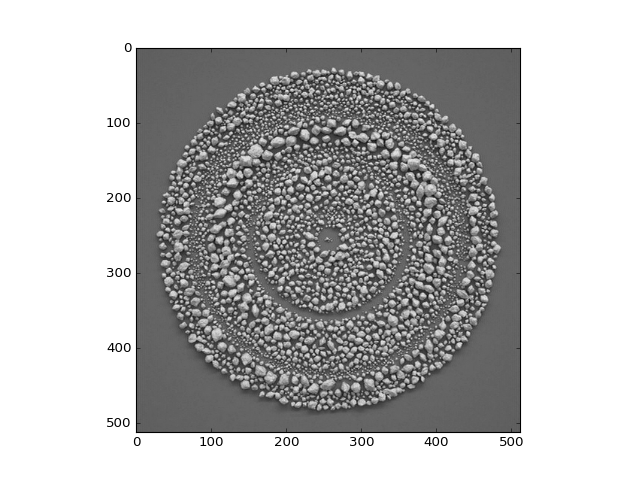

In [12]:
from lib.signalprocessingmd import convolution
lpw_image=np.zeros_like(model)
for i in range(lpw_image.shape[0]):
    lpw_image[i,:]=convolution(model[i,:],lpw)[m:-m]
plt.figure()
imshow(lpw_image,cmap='gray')

<IPython.core.display.Javascript object>


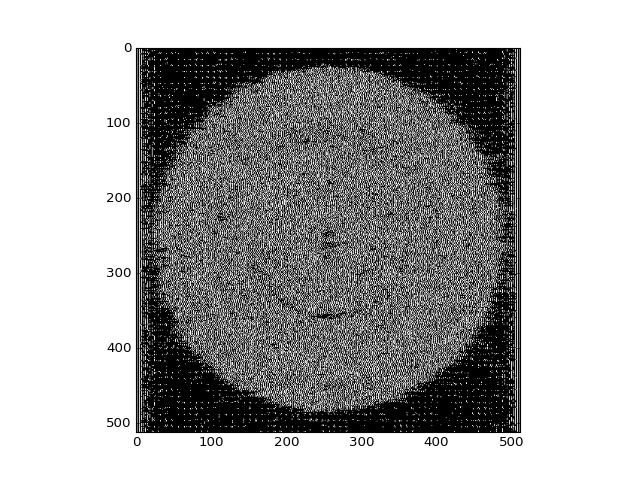

In [13]:
from lib.signalprocessingmd import convolution
hpw_image=np.zeros_like(model)
for i in range(hpw_image.shape[0]):
    hpw_image[i,:]=convolution(model[i,:],hpw)[m:-m]
plt.figure()
imshow(hpw_image,cmap='gray')

<IPython.core.display.Javascript object>


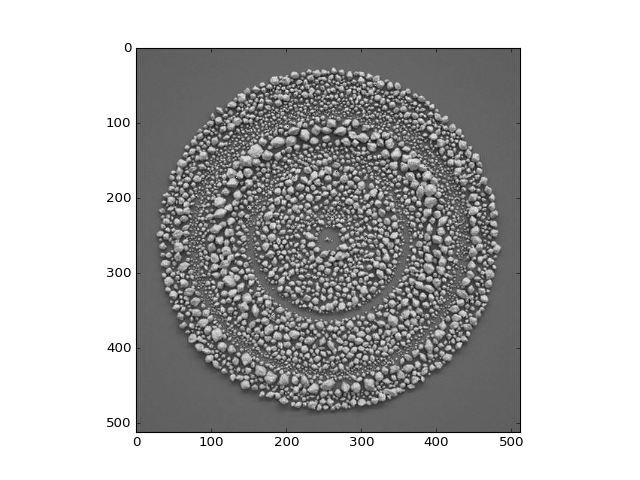

In [14]:
subst=lpw_image-hpw_image
plt.figure()
imshow(subst,'gray')

<IPython.core.display.Javascript object>


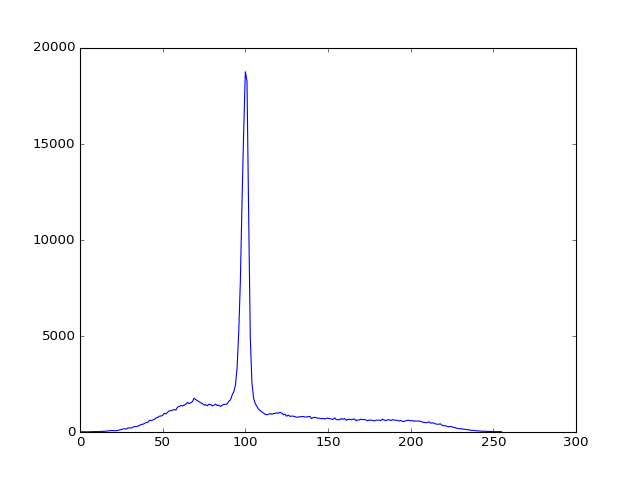

In [15]:
hist=[np.sum(subst==i) for i in range(256)]
plt.figure()
plt.plot(hist)

<IPython.core.display.Javascript object>


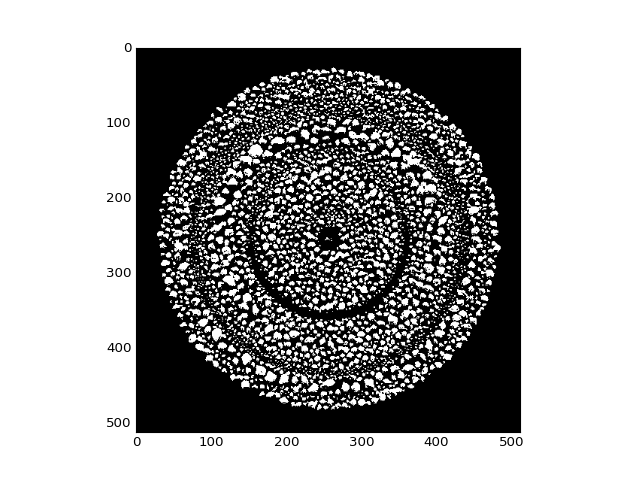

In [16]:
final=np.copy(subst)
final[final<135]=0
final[final>=135]=255
plt.figure()
imshow(final,cmap='gray')

In [17]:
def findLinesH(arr):
    res=np.zeros_like(arr).astype('int32')
    h,w=arr.shape
    for i in range(h):
        for j in range(w):
            if res[i,j]>0 or arr[i,j]==0:
                continue
            jend=j
            while jend<w and arr[i,jend]==255:jend+=1
            res[i,j:jend]=jend-j
    return res
def findLinesV(arr):
    res=np.zeros_like(arr).astype('int32')
    h,w=arr.shape
    for i in range(h):
        for j in range(w):
            if res[i,j]>0 or arr[i,j]==0:
                continue
            iend=i
            while iend<h and arr[iend,j]==255:iend+=1
            res[i:iend,j]=iend-i
    return res

def setVisited(varr,imgseg,r,c):
    h,w=arr.shape
    if r<0 or r>=h:return
    if c<0 or c>=w:return
    if varr[r,c]==1:return
    if imgseg[r,c]==0:return
    
    varr[r,c]=1
    setVisited(arr,imgseg,r+1,c)
    setVisited(arr,imgseg,r-1,c)
    setVisited(arr,imgseg,r,c+1)
    setVisited(arr,imgseg,r,c-1)
    return varr

def getDimentions(varr,hlines,vlines,i,j):
    h,w=arr.shape
    if i<0 or i>=h:return
    if j<0 or j>=w:return
    if varr[i,j]==1:return
    if hlines[i,j]==0:return
    mxh,mxw=hlines[i,j],vlines[i,j]
    varr[i,j]=1
    nh,nw=getDimentions(varr,hlines,vlines,i+1,j)
    mxh,mxw=max(mxh,nh),max(mxw,nw)
    nh,nw=getDimentions(varr,hlines,vlines,i-1,j)
    mxh,mxw=max(mxh,nh),max(mxw,nw)
    nh,nw=getDimentions(varr,hlines,vlines,i,j+1)
    mxh,mxw=max(mxh,nh),max(mxw,nw)
    nh,nw=getDimentions(varr,hlines,vlines,i,j-1)
    mxh,mxw=max(mxh,nh),max(mxw,nw)
    return mxh,mxw

In [18]:
H=findLinesH(final)
V=findLinesV(final)

In [19]:
def getComponentDimensions(varr,imgseg,H,V,r,c):
    # varr: 1 if visited
    
    h,w=varr.shape
    if r<0 or r>=h:return -1,-1
    if c<0 or c>=w:return -1,-1
    if varr[r,c]==1:return -1,-1
    if imgseg[r,c]==0:return -1,-1
    
    varr[r,c]=1
    mxH,mxV=H[r,c],V[r,c]
    nH,nV=getComponentDimensions(varr,imgseg,H,V,r+1,c)
    mxH,mxV=max(nH,mxH),max(nV,mxV)
    nH,nV=getComponentDimensions(varr,imgseg,H,V,r-1,c)
    mxH,mxV=max(nH,mxH),max(nV,mxV)
    nH,nV=getComponentDimensions(varr,imgseg,H,V,r,c+1)
    mxH,mxV=max(nH,mxH),max(nV,mxV)
    nH,nV=getComponentDimensions(varr,imgseg,H,V,r,c-1)
    mxH,mxV=max(nH,mxH),max(nV,mxV)
    return mxH,mxV

In [20]:
varr=np.zeros_like(final)
h,w=varr.shape
dimensions=[]
for i in range(h):
    for j in range(w):
        hl,vl=getComponentDimensions(varr,final,H,V,i,j)
        if hl>-1:
            dimensions.append((hl,vl))
            

In [21]:
dim=7
dimtups=[tup for tup in dimensions if max(tup[0],tup[1])==dim]
print("Number of stones: {}".format(len(dimensions)))
print("Number of stones of size {}: {}".format(dim,len(dimtups)))


Number of stones: 2866
Number of stones of size 7: 155
